# Introducing Climate Datasets


**Description & purpose**: This notebook is designed to introduce the user to model data held within the CMIP6 STAC and to suggest simple ways to visualise the information held within the NetCDF files that are accessed through the STAC asset URLs and Kerchunk reference files. It is assumed that this notebook will be run within the Notebook Service on the Hub.


# Introduction


The **Coupled Model Intercomparison Project Phase 6 (CMIP6)** is an international collaborative effort aimed at advancing our understanding of the Earth's climate system through standardised climate model experiments. It builds on the success of earlier phases of CMIP, providing a structured framework for comparing and improving climate models developed by research institutions worldwide. CMIP6 simulations include a wide range of scenarios, such as historical climate variations, future projections based on greenhouse gas emission trajectories, and experiments designed to isolate the effects of specific climate forcings (e.g. volcanic activity or solar variations). By providing consistent protocols and publicly available datasets, CMIP6 ensures that climate models can be systematically tested, benchmarked, and improved.

CMIP6 has a critical role in assessing the impacts of climate change and guiding global policy decisions and forms the scientific backbone for major climate assessments, such as those by the **Intergovernmental Panel on Climate Change (IPCC)**. The data generated by CMIP6 models underpin projections of global temperature rise, sea level changes, and the frequency and intensity of extreme weather events under different socioeconomic pathways. These insights are essential for governments, industries, and communities to make informed decisions about climate mitigation and adaptation strategies. CMIP6 also helps identify uncertainties in climate modeling, providing researchers with a roadmap for future model development. The EODH facilitates interdisciplinary research by providing open-access to the CMIP6 datasets. By fostering collaboration, transparency, and innovation, the EODH platform (and the CMIP6 data accessible through it) aspires to be a cornerstone of climate science.

The data is provided in its original **NetCDF (Network Common Data Form)** file format, a widely used standard for storing, sharing, and analyzing scientific data, particularly in the geosciences and climate sciences. NetCDF is designed to handle large, multi-dimensional datasets, such as temperature, precipitation, and wind speed, across space and time. Its self-describing format allows metadata (e.g. variable names, units, and coordinate information) to be embedded directly within the file, making the data easily interpretable and portable across platforms. Climate scientists use NetCDF because it is highly efficient for storing gridded data, supports parallel I/O for high-performance computing, and is compatible with a range of software tools, including Python. Additionally, the ability to represent data on multiple dimensions (e.g., latitude, longitude, time, and height) and its compression capabilities make it indispensable for managing the massive datasets generated by climate models and observational systems.

The CEDA STAC library also contains so-called reference files in **Kerchunk** format. Kerchunk is a lightweight reference file format that maps chunks of data in archival formats like NetCDF in a JSON file that can be lazily loaded to access only the required data chunks for any given request. Rather than converting the source NetCDF to a different format, Kerchunk contains pointers to individual chunks of data and uses the fsspec library to assemble those chunks into the required array in a tool like Xarray. Kerchunk files are also self-describing like NetCDF and include all the attributes and metadata from the files being referenced. CEDA's STAC catalog is continuously being updated with these reference assets, so the data can be accessed without downloading NetCDF files directly, as we will show here.

In [ ]:
# Notebook set-up

# Import the Python API Client
import pyeodh

# Import data handling and visualisation packages
# import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import geoviews as gv
import geoviews.feature as gf
from cartopy import crs

# Parameterise geoviews
gv.extension("bokeh", "matplotlib")

# Finding data


Information about the dataset we are interested in can be found [here](https://radiantearth.github.io/stac-browser/#/external/test.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/ceda-stac-catalogue/collections/cmip6/items/CMIP6.ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp126.r1i1p1f1.day.pr.gn.v20210317?.asset=asset-data0001).


In [ ]:
# Connect to the Hub
client = pyeodh.Client().get_catalog_service()
cmip6 = client.get_catalog("supported-datasets/ceda-stac-catalogue").get_collection(
    "cmip6"
)

cmip6.extent.to_dict()

# Look for a specific item
cmip6.get_item(
    "CMIP6.ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp126.r1i1p1f1.day.pr.gn.v20210317"
)

# Another way to do the item search and return an object
item_search = client.search(
    # collections=["cmip6"],
    ids=[
        "CMIP6.ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp126.r1i1p1f1.day.pr.gn.v20210317"
    ],
    limit=10,
)

Once the item has been searched for (the item name was taken from a visual search on the Hub web presence) then it is possible to find the data access URL. In the following example we already know the asset name but also demonstrate how to find that using dictionary keys.

In [4]:
for item in item_search:
    print(item)

In [5]:
item = item_search[0]
item

In [6]:
item.to_dict()

{'type': 'Feature',
 'stac_version': '1.0.0',
 'id': 'CMIP6.ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp126.r1i1p1f1.day.pr.gn.v20210317',
 'properties': {'datetime': '2276-01-01T00:00:00Z'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-179.0625, -89.375],
    [179.0625, -89.375],
    [179.0625, 89.375],
    [-179.0625, 89.375],
    [-179.0625, -89.375]]]},
 'links': [{'rel': 'self',
   'href': 'https://test.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/ceda-stac-catalogue/collections/cmip6/items/CMIP6.ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp126.r1i1p1f1.day.pr.gn.v20210317',
   'type': 'application/geo+json'},
  {'rel': 'parent',
   'href': 'https://test.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/ceda-stac-catalogue/collections/cmip6',
   'type': 'application/json'},
  {'rel': 'collection',
   'href': 'https://test.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/ceda-stac-catalogue/collections/cmip6',
   'type': 'application/js

# Visualising data


To enable us to view the information held in an individual CMIP6 NetCDf file we are going to use [Geoviews](https://geoviews.org/). The GeoViews Python package is a high-level library designed for interactive visualization of geospatial data, and built on top of the HoloViews library. GeoViews simplifies the creation of dynamic and rich visualisations that integrate geographic elements such as maps, satellite imagery, and geospatial datasets. It supports seamless interaction with popular geospatial libraries such as `cartopy`, GeoPandas and Shapely. GeoViews enables the overlaying of data on maps, customisation of visual styles, and interactivity such as zooming and panning.

First we need to access the data file and open it using xarray.


In [7]:
product = item.get_cloud_products()

In [8]:
data = product.open_dataset(local_only=True)
data

WARNING [ceda_datapoint.core.cloud]: Property "mapper_kwargs" for None is undefined.
/home/users/dwest77/cedadev/eodh-training/science/.venv/lib/python3.11/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/users/dwest77/cedadev/eodh-training/science/.venv/lib/python3.11/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/users/dwest77/cedadev/eodh-training/science/.venv/lib/python3.11/site-packages/xarray/core/indexing.py:525: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing usi

<xarray.Dataset> Size: 2GB
Dimensions:    (lat: 144, bnds: 2, lon: 192, time: 18262)
Coordinates:
  * lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon        (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
  * time       (time) object 146kB 2251-01-01 12:00:00 ... 2300-12-31 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 2GB dask.array<chunksize=(1, 144, 192), meta=np.ndarray>
    time_bnds  (time, bnds) object 292kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(30 April 2019) MD5:9328082e1e6d1da...
    title:                  ACCESS-CM2 output prepared for CMIP6
    tracking_id:            hdl:21.14100/d0f83bdc-dad3-41e5-9bcc-84c8c1cd099c
    variable_id:            pr
    variant_label:          r1i1p1f1
    version:                v20210317

In [9]:
f'{144*192*18262*32/1000000000:.2f} GB'

'16.16 GB'

We can see from the above, taking the precipitation flux (pr) variable as an example, that the data represented by this Dataset is well over 16 GB uncompressed. Thus in order to access any of the data without using Kerchunk, we would need to download at least 10 GB just for this one dataset. Clearly there is a better way, especially since it is unlikely we will need to access the entire array for any of our analyses. 

In the example below we take only the first time step, which most likely relates to just the first chunk of data using the Kerchunk file.

## 1. Plot a single time-step

From the above information (and the file name) we can see that the dataset contained in the NetCDF file is precipitation flux (pr). There are a large number of timeperiods that have been included in the file. We can plot a single slice of the data using GeoViews as laid out in the following code.


In [10]:
%matplotlib inline
# select the first time step
oneframe = data.pr.isel(time=0)

# generate the image to show
figdata = gv.Dataset(oneframe, ["lon", "lat"], crs=crs.PlateCarree())
images = figdata.to(gv.Image)

# Plot
images.opts(cmap="viridis", colorbar=True, width=600, height=500) * gf.coastline

:Overlay
   .Image.I     :Image   [lon,lat]   (Precipitation)
   .Coastline.I :Feature   [Longitude,Latitude]

## 2. Plot a regional average

We can perform multiple selections and operations on the data lazily, where those operations are not computed until the data is plotted at the end. Here we take an example of selecting some cloud height data and plotting the average over a period of 5 years.

In [11]:
# Another way to do the item search and return an object
item_search = client.search(
    # collections=["cmip6"],
    ids=[
        "CMIP6.ScenarioMIP.MRI.MRI-ESM2-0.ssp119.r1i1p1f1.Amon.clt.gn.v20190222"
    ],
    limit=10,
)
item=item_search[0]

We can very quickly retrieve the cloud-format product to use for accessing the data.

In [12]:
product = item.get_cloud_products()
product

<DataPointCloudProduct: CMIP6.ScenarioMIP.MRI.MRI-ESM2-0.ssp119.r1i1p1f1.Amon.clt.gn.v20190222-reference_file (Format: kerchunk)>
 - bbox: [-180.0, -89.14152, 178.875, 89.14152]
 - asset_id: CMIP6.ScenarioMIP.MRI.MRI-ESM2-0.ssp119.r1i1p1f1.Amon.clt.gn.v20190222-reference_file
 - cloud_format: kerchunk
Attributes:
 - datetime: 2057-12-31T12:00:00+00:00

In [13]:
ds = product.open_dataset()
ds

WARNING [ceda_datapoint.core.cloud]: Property "mapper_kwargs" for None is undefined.


<xarray.Dataset> Size: 211MB
Dimensions:    (time: 1032, lat: 160, lon: 320, bnds: 2)
Coordinates:
  * lat        (lat) float64 1kB -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
  * lon        (lon) float64 3kB 0.0 1.125 2.25 3.375 ... 356.6 357.8 358.9
  * time       (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12-16T1...
Dimensions without coordinates: bnds
Data variables:
    clt        (time, lat, lon) float32 211MB dask.array<chunksize=(1, 160, 320), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 3kB dask.array<chunksize=(160, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 5kB dask.array<chunksize=(320, 2), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] 17kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    cmor_version:           3.4.0
    ...                     ...
    table_id:               Amon
    table_info:             Creation Date:(14 December 2018) MD5:b2d32d1a0d9b...
    title:                  MRI-ESM2-0 output prepared for CMIP6
    tracking_id:            hdl:21.14100/3fef816c-0095-4950-a45a-ba080ec2b7eb
    variable_id:            clt
    variant_label:          r1i1p1f1

Applying our data slices and analyses can be performed in a few short steps that takes very little time thanks to the lazily loaded dataset.

In [14]:
ds.clt

<xarray.DataArray 'clt' (time: 1032, lat: 160, lon: 320)> Size: 211MB
dask.array<open_dataset-clt, shape=(1032, 160, 320), dtype=float32, chunksize=(1, 160, 320), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 1kB -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 3kB 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
  * time     (time) datetime64[ns] 8kB 2015-01-16T12:00:00 ... 2100-12-16T12:...
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Total cloud area fraction for the whole atmospheric colum...
    history:        2019-02-20T14:25:47Z altered by CMOR: replaced missing va...
    long_name:      Total Cloud Cover Percentage
    original_name:  TCLOUD
    standard_name:  cloud_area_fraction
    units:          %

In [15]:
%%time
time_series = ds.time.dt.year.isin([2015+i for i in range(5)])
oneframe = ds.clt.isel(time=time_series).sel(lon=slice(220,340), lat=slice(-60,60)).mean(dim='time')

CPU times: user 15.4 ms, sys: 2.15 ms, total: 17.5 ms
Wall time: 18.8 ms


Basic plot of the Americas - average cloud cover percentage over a 5 year period (2015-2020)

Text(0, 0.5, 'Latitude')

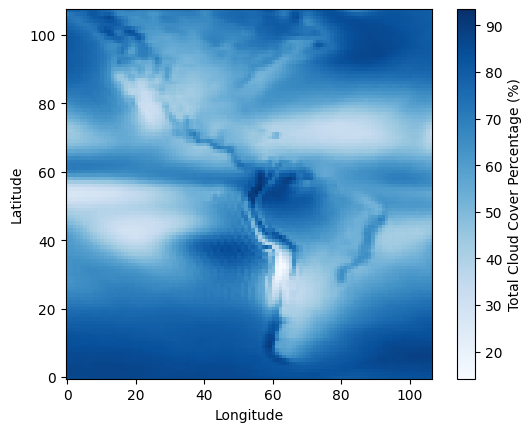

In [16]:
# Generate a plain image to show
plt.imshow(oneframe.compute(), origin='lower',cmap='Blues') # We need the 'lower' option to flip the image because the latitude coordinates for this dataset start from -90.
plt.colorbar(label=f'{ds.clt.long_name} ({ds.clt.units})')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

The above image well represents the underlying data in terms of arrangement and resolution, and we can even see the outlines of continents where the land-sea border has an effect on the cloud cover percentage (clt).

If we want to have the coastlines added, plus a different projection method for the map, we can use the Geoviews package to arrange the data in this new way.

**Note**: Using different projections may add some apparent artifacts to the data, as we can see below. This is probably due to the data conversion to Geoviews and is a good example of why using multiple plots is a valuable filter for unexpected results.

In [17]:
# generate the image to show
figdata = gv.Dataset(oneframe.compute(), ["lon", "lat"], crs=crs.PlateCarree())
images = figdata.to(gv.Image)

# Plot
images.opts(cmap="viridis", colorbar=True, width=600, height=500) * gf.coastline

:Overlay
   .Image.I     :Image   [lon,lat]   (clt)
   .Coastline.I :Feature   [Longitude,Latitude]

## 3. Plot some assembled data

Here we plot an example set of data for the years 2251 to 2311 within this model forecase for the Precipitation Flux (pr) variable. We are specifically looking at the mean rainfall in the summer months June-August across the globe. We can select these data from the Xarray dataset, combine them into an array of mean values and plot 

In [18]:
# Define our filter based on the desired months.
summer = data.time.dt.month.isin([6,7,8])

years  = []
values = []
for i in range(60): # Arbitrary 60-year time-series.

    # Define a filter for each year and use to calculate the mean value.
    yr_filter = data.time.dt.year.isin([2251+i])
    value = data.pr.isel(time=summer&yr_filter).mean().compute()

    # Concatenate values
    values.append(value)
    years.append(2251+i)

**Note**: When plotting data in this fashion, it is best to retrieve all the data you're definitely going to need, using the `.compute()` function. This should only be done at the point where all the data will be required so you can take advantage of the lazy loading as far as possible, but by fetching the data slightly sooner, you are avoiding the potential for duplicate retrievals. In our example above, if the data chunks each contain multiple years, then our data requests in each loop will likely try to fetch the same data multiple times over the network.

We can already guess the expected results but we can see it clearly from the `values` parameter: There isn't a lot of variation in Precipitation for this set of time periods expected within this data, the average is fairly constant.

In [19]:
np.array(values)

array([3.2855816e-05, 3.2685162e-05, 3.3101434e-05, 3.2580436e-05,
       3.3071603e-05, 3.2749525e-05, 3.2923213e-05, 3.2849730e-05,
       3.2942939e-05, 3.2836724e-05, 3.2885007e-05, 3.3062988e-05,
       3.2747223e-05, 3.2915803e-05, 3.2871350e-05, 3.2934004e-05,
       3.2730630e-05, 3.2895732e-05, 3.2411441e-05, 3.2801654e-05,
       3.2587293e-05, 3.3185788e-05, 3.2788066e-05, 3.3151795e-05,
       3.3164430e-05, 3.2921696e-05, 3.3123262e-05, 3.2765842e-05,
       3.2568005e-05, 3.2715379e-05, 3.3246262e-05, 3.2860520e-05,
       3.2898555e-05, 3.3144406e-05, 3.2595581e-05, 3.2835953e-05,
       3.2745345e-05, 3.2944168e-05, 3.2687018e-05, 3.2905038e-05,
       3.2768705e-05, 3.2982960e-05, 3.2923665e-05, 3.2810131e-05,
       3.2835127e-05, 3.3216886e-05, 3.2803429e-05, 3.2939348e-05,
       3.2507061e-05, 3.2745895e-05,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           

Finally we can plot this data as a simple scatter plot.

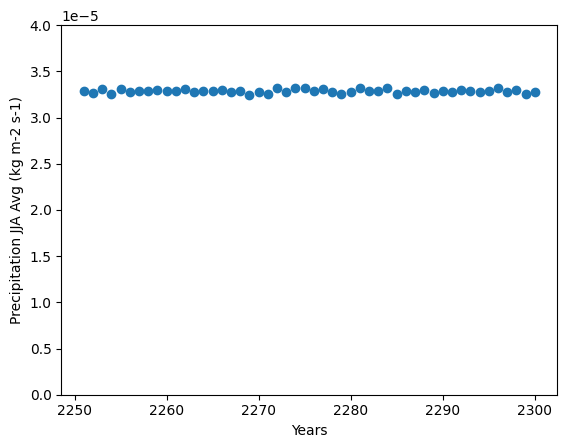

In [20]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.ylim(0,4e-5)
plt.ylabel(f'{data.pr.long_name} JJA Avg ({data.pr.units})')
plt.xlabel('Years')
plt.scatter(np.array(years),np.array(values))

## 4. Animations across a time-series

It would be useful if a user was able to move through the data and understand the changes in the supplied data as the time periods change. This is where Geoviews really helps.


In [21]:
%%time
# Load the data selection in Xarray
data2 = data.isel(time=slice(0, 50)).sel(lat=slice(-30,30)).compute()

CPU times: user 552 ms, sys: 89.7 ms, total: 642 ms
Wall time: 499 ms


**Note**: It is best to load the data into geoviews at this point (losing the lazy loading) because the output generation takes considerably longer than the data loading, and this causes more frequent connection issues when awaiting http-requested chunks.

In this case, because we are using a Cloud-based dataset which retrieves data by request, it is best to load our data into an array at this stage, rather than pass the unloaded dataset to Geoviews. This notebook has been written in this way because it was noted that Geoviews is more prone to request-based failures to fetch data, most likely because in converting the data it attempts to access data selections multiple times, which triggers multiple requests for the same portion of data.

In [22]:
%%time
# Create a Geoviews dataset and convert to the required format for visualisation
dataset = gv.Dataset(data2)
ensemble = dataset.to(gv.Image, ["lon", "lat"], "pr")

CPU times: user 221 ms, sys: 2.56 ms, total: 223 ms
Wall time: 222 ms


We can see the above two sections - where we have retrieved the data and assembled a Geoviews dataset - have short durations in terms of computation time. The cell below generates the interactive animation, which even for 50 selections of pre-loaded data takes significantly longer to assemble.

:HoloMap   [time]
   :Overlay
      .Image.I     :Image   [lon,lat]   (Precipitation)
      .Coastline.I :Feature   [Longitude,Latitude]
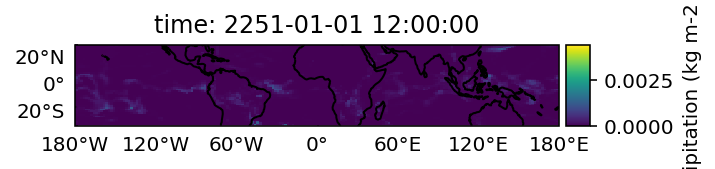
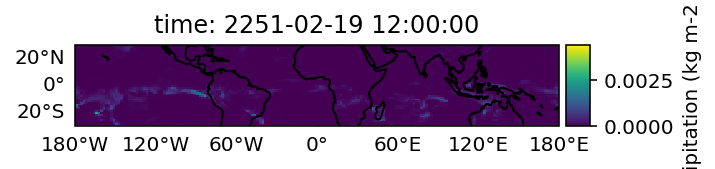
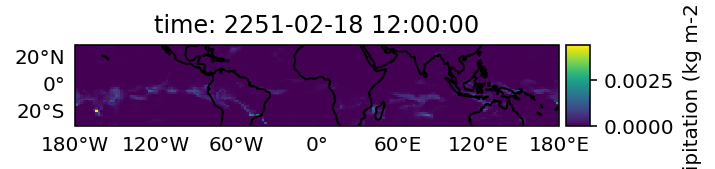
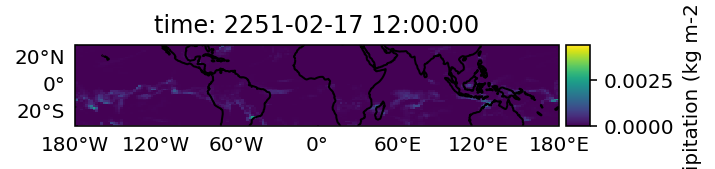
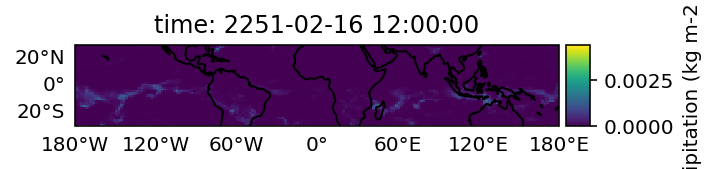
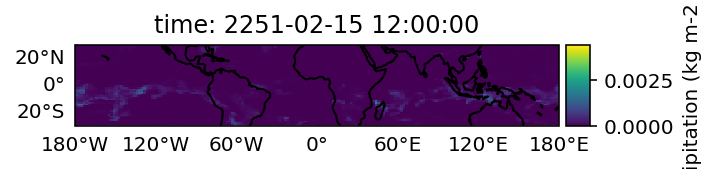
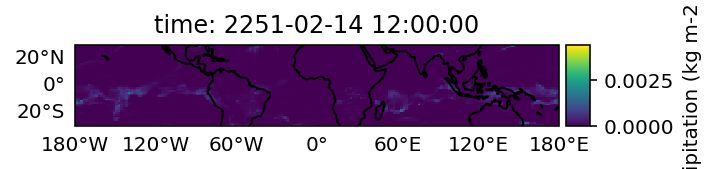
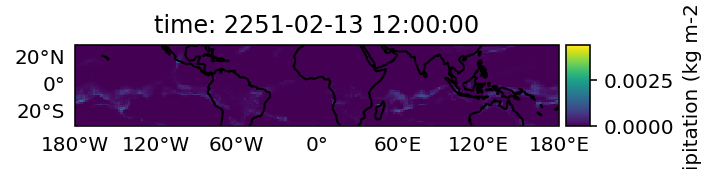
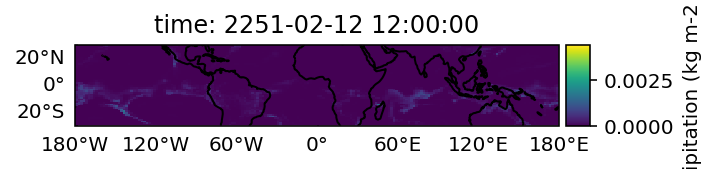
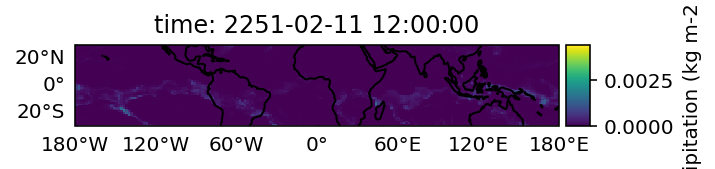
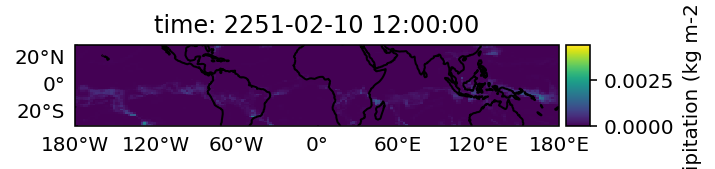
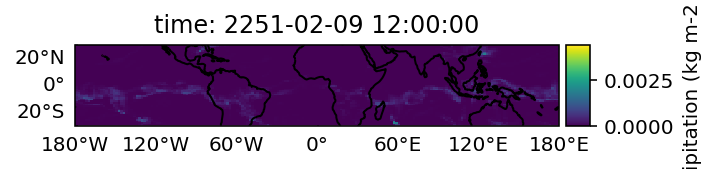
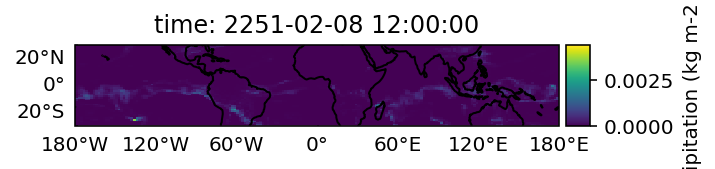
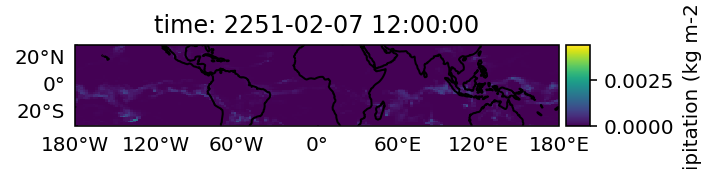
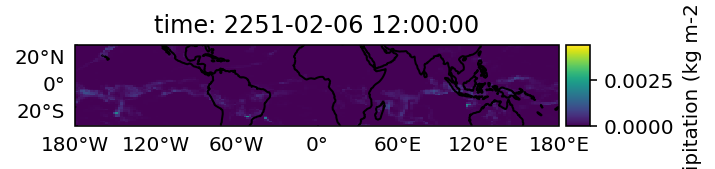
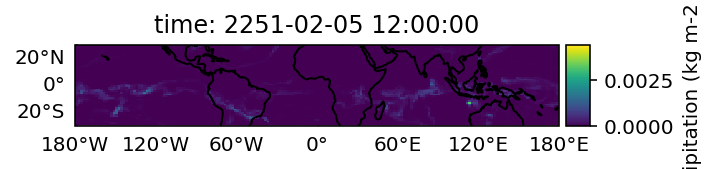
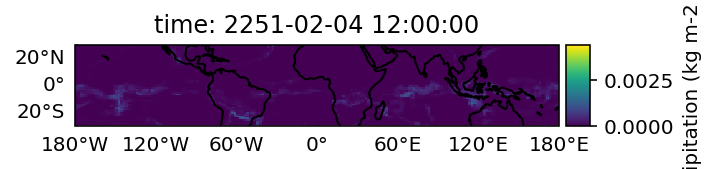
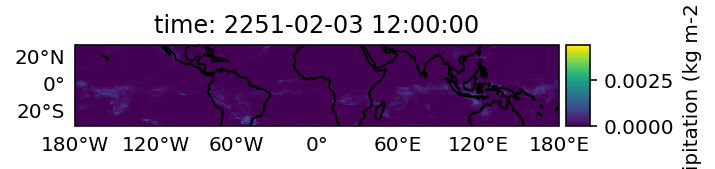
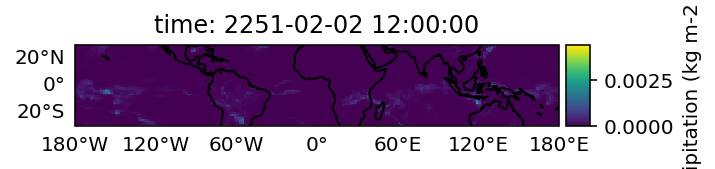
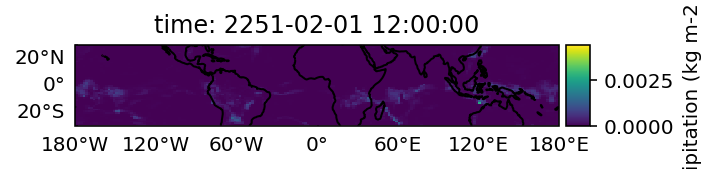
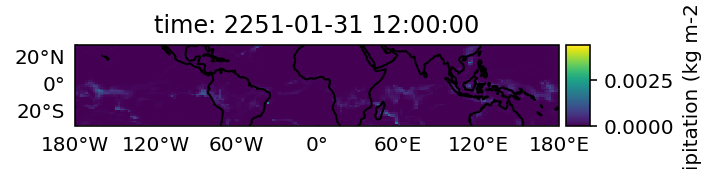
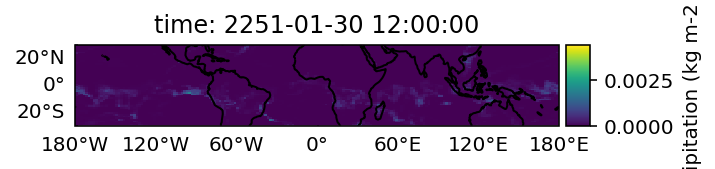
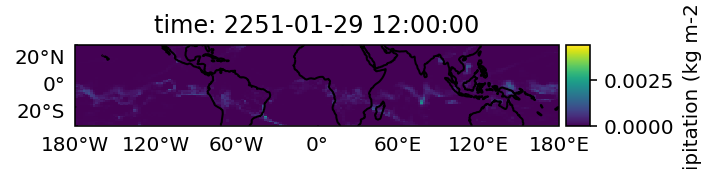
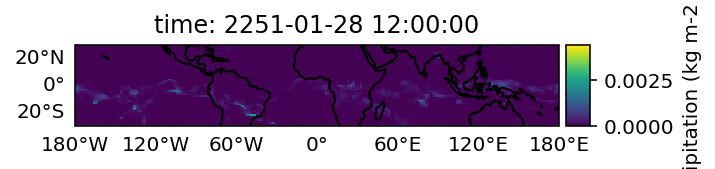
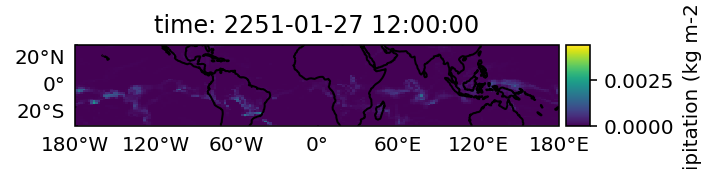
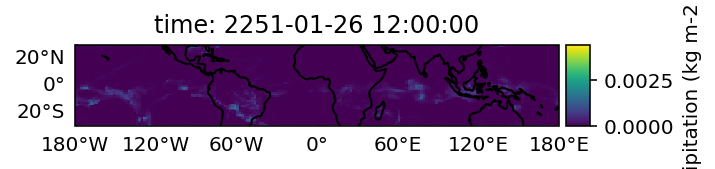
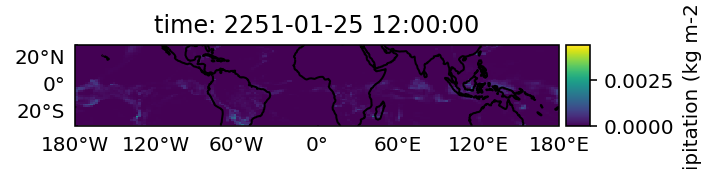
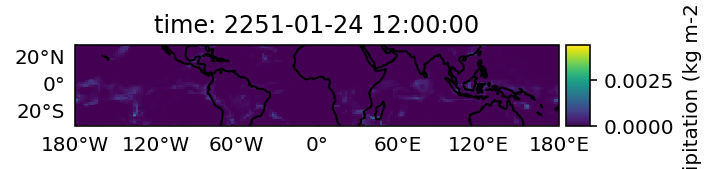
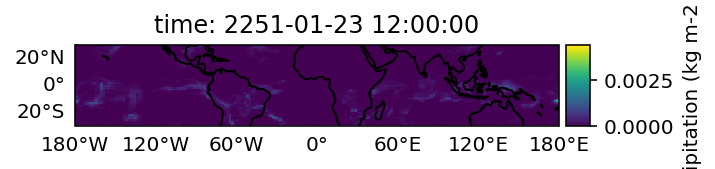
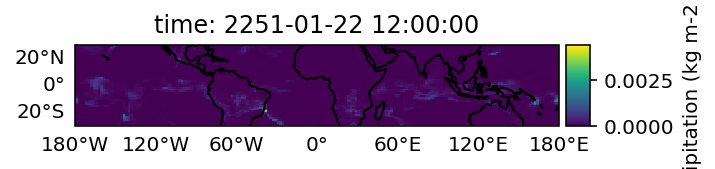
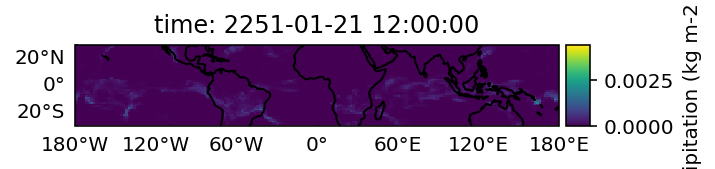
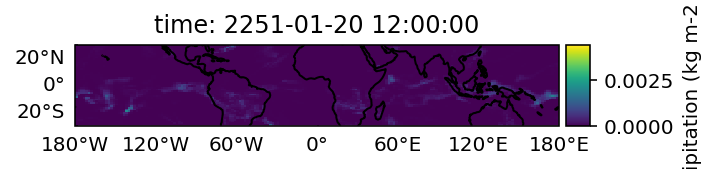
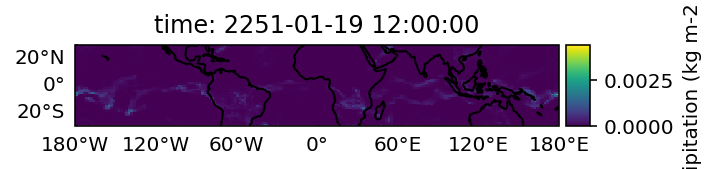
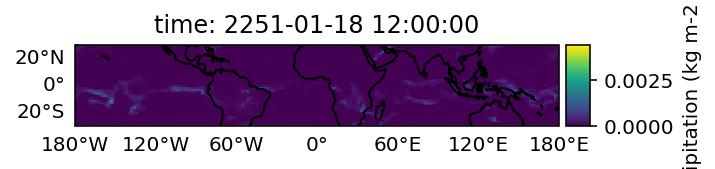
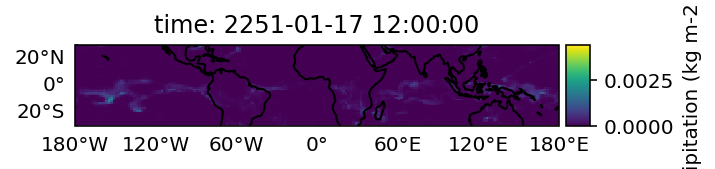
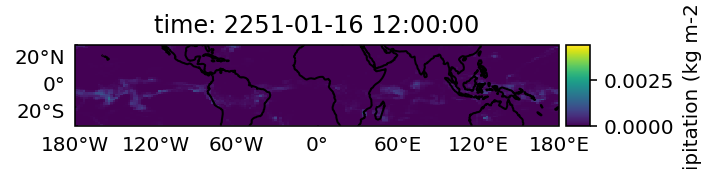
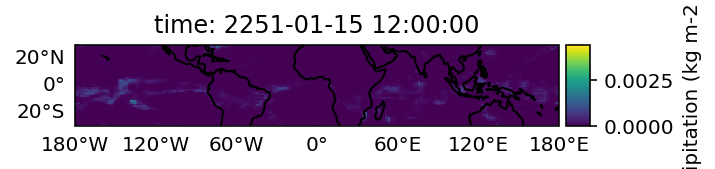
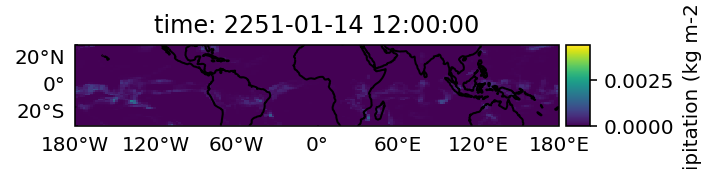
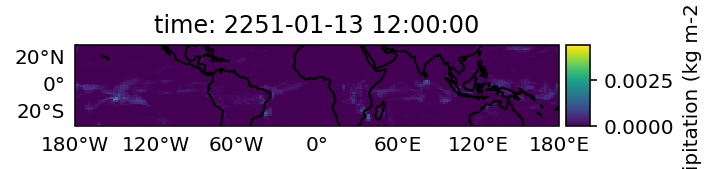
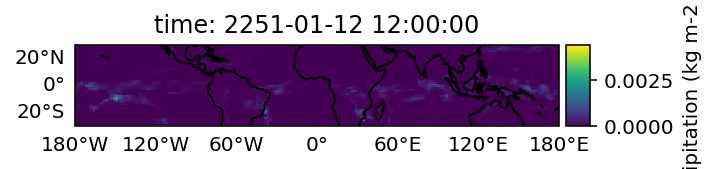
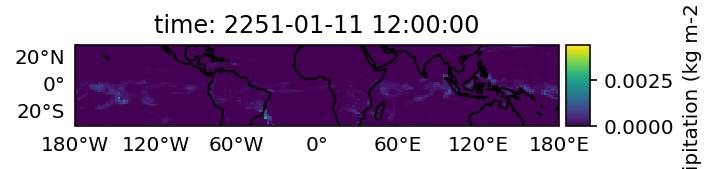
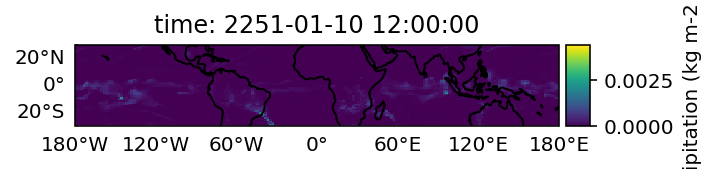
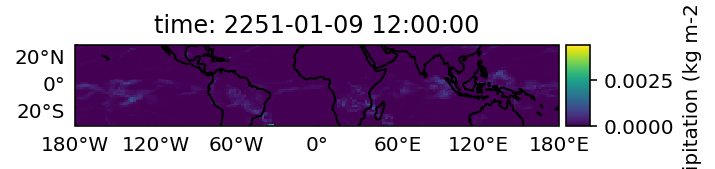
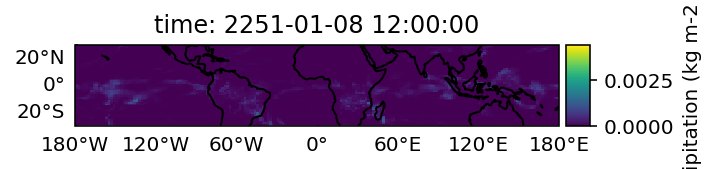
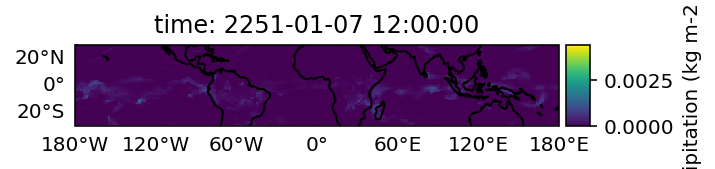
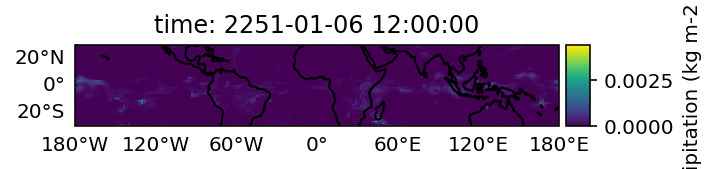
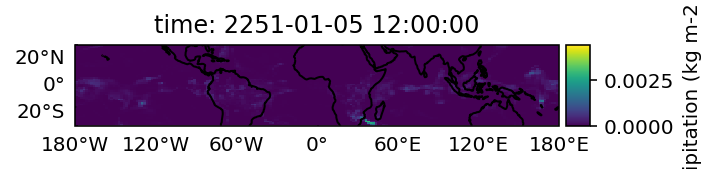
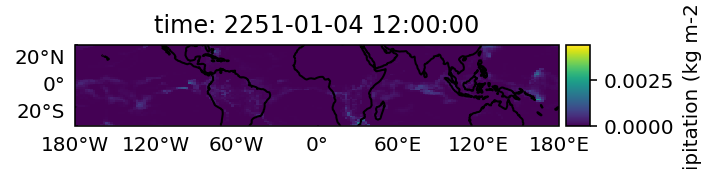
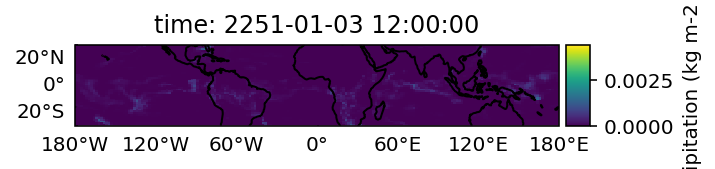
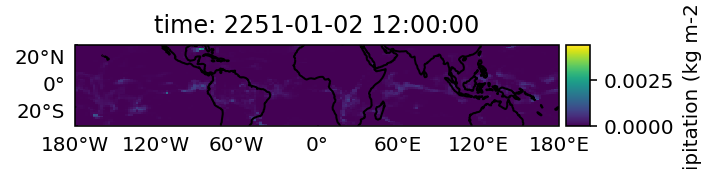
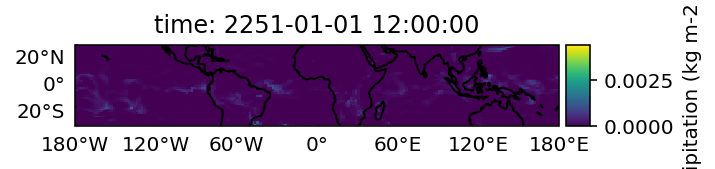

CPU times: user 3min 2s, sys: 53.1 s, total: 3min 55s
Wall time: 2min 30s


In [23]:
%%time
# Generate the interactive annimation
gv.output(
    ensemble.opts(cmap="viridis", colorbar=True, fig_size=120, backend="matplotlib")
    * gf.coastline(),
    backend="matplotlib",
    widget_location="top",
    max_frames=200,
)

Use the time slider above the figure to step through the spatial dataset held within this dataset. The Geoviews package and Holoviews suite of tools are very powerful when building interactive components to help scientists and users understand these complex datasets. If the colormap doesn't work for you alternatibves can be found [here](https://holoviews.org/user_guide/Colormaps.html).


In [24]:
# # Close the dataset to free resources
data.close()

# See also

More information about handling CMIP6 data can be found through [this notebook](https://github.com/cedadev/ceda-notebooks/blob/master/notebooks/data-notebooks/cmip6/cmip6-zarr-jasmin.ipynb) from CEDA.